# Big Data Tools for Business Project: Part 2

This part of the project is to analyze the data of the real estate market of France across different cities to see what trend, tendancy, characteristics, and pattern the market has.

In [1]:
import pyspark

In [2]:
spark = pyspark.sql.SparkSession.builder.appName("Big Data Tools for Business Project Part 2").getOrCreate()

In [3]:
# read the data

from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import FloatType

df = spark.read.csv('real_estate_transactions.csv', header = True, sep = ';')

df.show(5)

+----+----------+---------+---------+-----------+-------+--------------+----------+-----------+---------------+---------+
|City| Sale Date|Sale Type|    Price|Postal Code|Commune|Number of lots|Local Type|Living Area|Number of rooms|Land Area|
+----+----------+---------+---------+-----------+-------+--------------+----------+-----------+---------------+---------+
|NICE|26/03/2015|     SALE|102000,00|       6000|   NICE|             1| APARTMENT|         29|              2|     null|
|NICE|07/04/2015|     SALE| 32000,00|       6000|   NICE|             1|DEPENDENCY|          0|              0|     null|
|NICE|10/04/2015|     SALE|239000,00|       6200|   NICE|             1| APARTMENT|         51|              2|     null|
|NICE|10/04/2015|     SALE|239000,00|       6200|   NICE|             1|DEPENDENCY|          0|              0|     null|
|NICE|23/03/2015|     SALE| 30000,00|       6000|   NICE|             1|DEPENDENCY|          0|              0|     null|
+----+----------+-------

In [4]:
# read the Price column with "." instead of "," and insert a new column with correct punctutations, namely Price_new
# the program can't read a price with "," as a decimal point

df = df.withColumn('Price_new', regexp_replace('Price', '\\.', ''))
df = df.withColumn('Price_new', regexp_replace('Price', ',', '.'))
df = df.withColumn('Price_new', df['Price_new'].cast("float"))

df = df.drop('Price')

df.show(5)

+----+----------+---------+-----------+-------+--------------+----------+-----------+---------------+---------+---------+
|City| Sale Date|Sale Type|Postal Code|Commune|Number of lots|Local Type|Living Area|Number of rooms|Land Area|Price_new|
+----+----------+---------+-----------+-------+--------------+----------+-----------+---------------+---------+---------+
|NICE|26/03/2015|     SALE|       6000|   NICE|             1| APARTMENT|         29|              2|     null| 102000.0|
|NICE|07/04/2015|     SALE|       6000|   NICE|             1|DEPENDENCY|          0|              0|     null|  32000.0|
|NICE|10/04/2015|     SALE|       6200|   NICE|             1| APARTMENT|         51|              2|     null| 239000.0|
|NICE|10/04/2015|     SALE|       6200|   NICE|             1|DEPENDENCY|          0|              0|     null| 239000.0|
|NICE|23/03/2015|     SALE|       6000|   NICE|             1|DEPENDENCY|          0|              0|     null|  30000.0|
+----+----------+-------

In [5]:
# export the csv file for reading data later

df.coalesce(1).write.csv('real_estate_transactions_revised')

AnalysisException: path file:/Users/ching/Desktop/Class/Big Data Analytics/Big Data Tools for Business/Project/real_estate_transactions_revised.csv already exists.;

In [6]:
# know the names and datatype of the schema

df.printSchema()

root
 |-- City: string (nullable = true)
 |-- Sale Date: string (nullable = true)
 |-- Sale Type: string (nullable = true)
 |-- Postal Code: string (nullable = true)
 |-- Commune: string (nullable = true)
 |-- Number of lots: string (nullable = true)
 |-- Local Type: string (nullable = true)
 |-- Living Area: string (nullable = true)
 |-- Number of rooms: string (nullable = true)
 |-- Land Area: string (nullable = true)
 |-- Price_new: float (nullable = true)



In [7]:
# use the following schema to import our dataframe (with new columns names and suitable datatypes)

from pyspark.sql.types import *

real_schema = StructType ( [StructField("city", StringType(), True),
                             StructField("sale_date", DateType(), True),
                             StructField("sale_type", StringType(), True),
                             StructField("postal_code", IntegerType(), True),
                             StructField("commune", StringType(), True),
                             StructField("number_of_lots", IntegerType(), True),
                             StructField("local_type", StringType(), True),
                             StructField("living_area", DoubleType(), True),
                             StructField("number_of_rooms", IntegerType(), True),
                             StructField("land_area", DoubleType(), True),
                             StructField("price", FloatType(), True),]
                        )    

In [8]:
# read again the sales.csv file, with the previous defined schema
# as the file generated in the previous step has a random name, you have to change the file name in the below path 
# in order to read it

spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

df = spark.read.csv('/Users/ching/Desktop/Class/Big Data Analytics/Big Data Tools for Business/Project/real_estate_transactions_revised.csv/part-00000-e0e79b53-fdee-4360-8532-d051d2641f75-c000.csv', 
                    header = True, sep = ',', dateFormat='dd/MM/YYYY', schema = real_schema)

df.show(10)

+----+----------+---------+-----------+-------+--------------+----------+-----------+---------------+---------+--------+
|city| sale_date|sale_type|postal_code|commune|number_of_lots|local_type|living_area|number_of_rooms|land_area|   price|
+----+----------+---------+-----------+-------+--------------+----------+-----------+---------------+---------+--------+
|NICE|2015-04-07|     SALE|       6000|   NICE|             1|DEPENDENCY|        0.0|              0|     null| 32000.0|
|NICE|2015-04-10|     SALE|       6200|   NICE|             1| APARTMENT|       51.0|              2|     null|239000.0|
|NICE|2015-04-10|     SALE|       6200|   NICE|             1|DEPENDENCY|        0.0|              0|     null|239000.0|
|NICE|2015-03-23|     SALE|       6000|   NICE|             1|DEPENDENCY|        0.0|              0|     null| 30000.0|
|NICE|2015-03-23|     SALE|       6200|   NICE|             2| APARTMENT|       60.0|              3|     null|410000.0|
|NICE|2015-04-08|     SALE|     

In [9]:
# register the df DataFrame as a temporary view with the name 'real' for further spark sql queries

df.createOrReplaceTempView('real')

# 1. Find Price Outliers

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from matplotlib import pyplot

In [11]:
# extract the column of sale date

price_outliers = spark.sql("SELECT sale_date, price FROM real")

price_outliers.show(5)

+----------+--------+
| sale_date|   price|
+----------+--------+
|2015-04-07| 32000.0|
|2015-04-10|239000.0|
|2015-04-10|239000.0|
|2015-03-23| 30000.0|
|2015-03-23|410000.0|
+----------+--------+
only showing top 5 rows



In [12]:
# we need to convert the dataframe to Pandas and date data type for plotting the graph

price_outliers_pd = price_outliers.toPandas()
price_outliers_pd['sale_date'] = pd.to_datetime(price_outliers_pd['sale_date'])

price_outliers_pd.head()

,sale_date,price
0,2015-04-07,32000.0
1,2015-04-10,239000.0
2,2015-04-10,239000.0
3,2015-03-23,30000.0
4,2015-03-23,410000.0


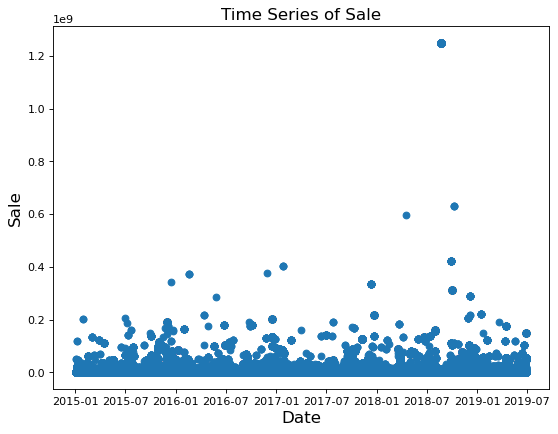

In [13]:
# plot the graph of all data to spot the outliers

figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.title('Time Series of Sale', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sale', fontsize = 15)
plt.plot(price_outliers_pd['sale_date'], price_outliers_pd['price'], 'o')
plt.show()

It is obvious that values larger than 20,000,000 are outliers. Most of the data lie below this threshold.

# 2. Price Distribution Over Time

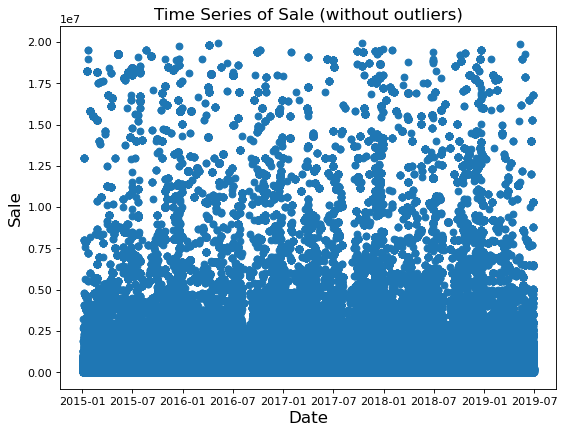

In [14]:
# plot the same graph without outliers

price_outliers_pd_wo = price_outliers_pd[price_outliers_pd['price'] < 20000000]

figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.title('Time Series of Sale (without outliers)', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sale', fontsize = 15)
plt.plot(price_outliers_pd_wo['sale_date'], price_outliers_pd_wo['price'], 'o')
plt.show()

There is no specific trend or pattern among the data as time passes. More data scatter over values smaller than 5,000,000.

# 3. Average Living Area

In [15]:
# extract the column living area

living_area = spark.sql("SELECT sale_date, living_area FROM real ORDER BY living_area DESC")

living_area.show(5)

+----------+-----------+
| sale_date|living_area|
+----------+-----------+
|2015-11-25|    49072.0|
|2019-01-16|    48000.0|
|2016-07-28|    37655.0|
|2016-02-18|    36296.0|
|2015-05-06|    34420.0|
+----------+-----------+
only showing top 5 rows



In [16]:
# convert data to Pandas and date to date type

living_area_pd = living_area.toPandas()
living_area_pd['sale_date'] = pd.to_datetime(living_area_pd['sale_date'])

living_area_pd.head()

,sale_date,living_area
0,2015-11-25,49072.0
1,2019-01-16,48000.0
2,2016-07-28,37655.0
3,2016-02-18,36296.0
4,2015-05-06,34420.0


### a. Find Living Area Outliers

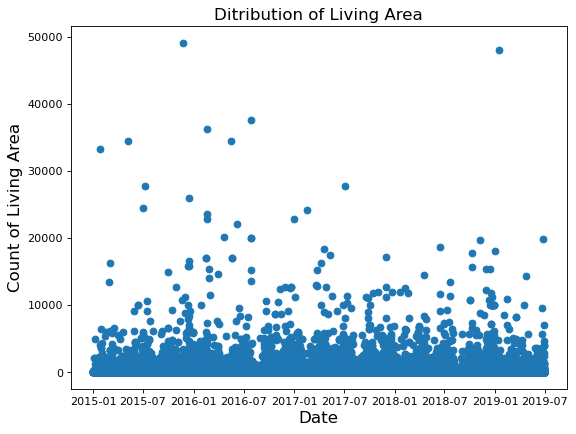

In [17]:
# plot the graph of living area to spot outliers

figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.title('Ditribution of Living Area', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Count of Living Area', fontsize = 15)

plt.plot(living_area_pd['sale_date'], living_area_pd['living_area'], 'o')
plt.show()

Outliers are larger than 5,000. It seems that living area has no correlation with time. 

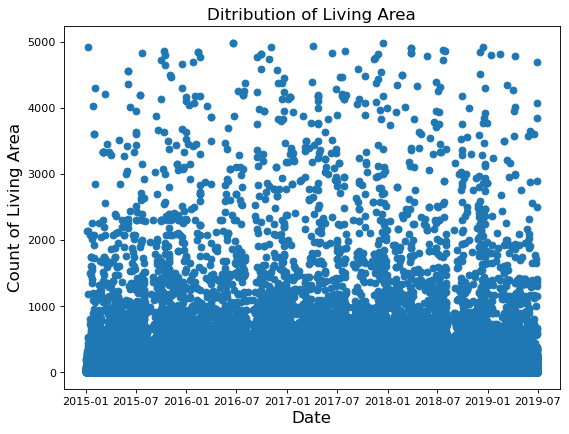

In [18]:
# plot the graph of living area without outliers

living_area_pd_wo = living_area_pd[living_area_pd['living_area'] < 5000]

figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.title('Ditribution of Living Area', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Count of Living Area', fontsize = 15)

plt.plot(living_area_pd_wo['sale_date'], living_area_pd_wo['living_area'], 'o')
plt.show()

The majority of living area lies below 2,000 and time has no effect on living area.

### b. Calculate Average Living Area

In [19]:
# extract sale date and calculate price per square metre

price_per_m2 = spark.sql("SELECT sale_date, (price/living_area) AS price_per_m2 \
                        FROM real WHERE price < 20000000 AND living_area != 0 AND living_area < 5000 \
                        ORDER BY price_per_m2 DESC")

price_per_m2.show(5)

+----------+------------+
| sale_date|price_per_m2|
+----------+------------+
|2015-11-25|      1.83E7|
|2015-11-25|      1.83E7|
|2015-11-25|      1.83E7|
|2015-11-25|      1.83E7|
|2015-11-25|      1.83E7|
+----------+------------+
only showing top 5 rows



In [20]:
# convert data to Pandas and sale date to date data type

price_per_m2_pd = price_per_m2.toPandas()
price_per_m2_pd['sale_date'] = pd.to_datetime(price_per_m2_pd['sale_date'])

price_per_m2_pd.head()

,sale_date,price_per_m2
0,2015-11-25,18300000.0
1,2015-11-25,18300000.0
2,2015-11-25,18300000.0
3,2015-11-25,18300000.0
4,2015-11-25,18300000.0


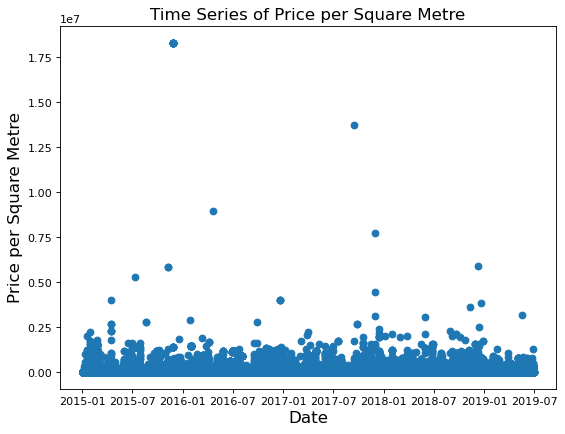

In [21]:
# plot the time series of price per square metre

figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.title('Time Series of Price per Square Metre', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Price per Square Metre', fontsize = 15)

plt.plot(price_per_m2_pd['sale_date'], price_per_m2_pd['price_per_m2'], 'o')
plt.show()

Without the outliers of price and living area, we can still observe abnormal large values amoong price per square metre. Hence we can deduce that the values come from average values of price and extremely low values of living area.

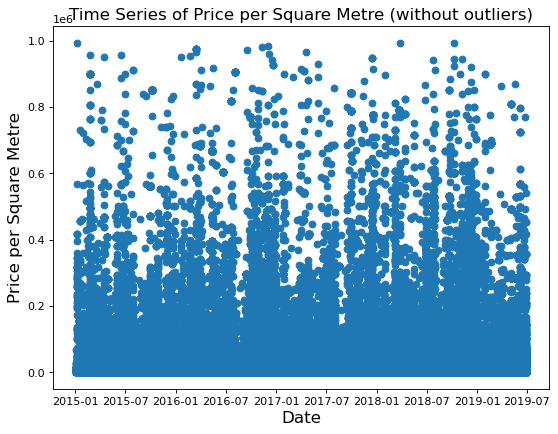

In [22]:
# plot the time series of price per square metre without outliers

price_per_m2_pd_wo = price_per_m2_pd[price_per_m2_pd['price_per_m2'] < 1000000]

figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.title('Time Series of Price per Square Metre (without outliers)', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Price per Square Metre', fontsize = 15)

plt.plot(price_per_m2_pd_wo['sale_date'], price_per_m2_pd_wo['price_per_m2'], 'o')
plt.show()

Without outliers, we can conclude that the price per square metre has no obvious relationship with time. 

# 4. Average Prices of Different Cities

In [23]:
# extract city and average price columns

price_city = spark.sql("SELECT city, avg(price) AS average_price FROM real WHERE price < 20000000 \
                       GROUP BY city ORDER BY average_price")

price_city.show()

+-----------+-----------------+
|       city|    average_price|
+-----------+-----------------+
|       NICE|  421657.52142506|
|   TOULOUSE|520645.8212854697|
|      LILLE|570800.2920916472|
|     NANTES|577670.9128914537|
|  MARSEILLE|632366.1585518621|
|MONTPELLIER|650088.2290373697|
|   BORDEAUX|734408.6384075799|
|       LYON|820476.3538805211|
|      PARIS|1075180.645645533|
+-----------+-----------------+



In [24]:
# convert data to Pandas

price_city_pd = price_city.toPandas()

price_city_pd

,city,average_price
0,NICE,4.216575e+05
1,TOULOUSE,5.206458e+05
2,LILLE,5.708003e+05
3,NANTES,5.776709e+05
4,MARSEILLE,6.323662e+05
5,MONTPELLIER,6.500882e+05
6,BORDEAUX,7.344086e+05
7,LYON,8.204764e+05
8,PARIS,1.075181e+06


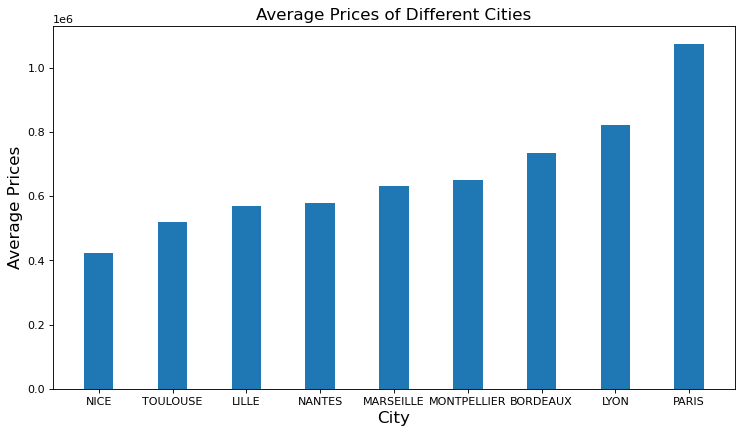

In [25]:
# plot the graph of average price against different cities 

figure(num = None, figsize = (11, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.title('Average Prices of Different Cities', fontsize = 15)
plt.xlabel('City', fontsize = 15)
plt.ylabel('Average Prices', fontsize = 15)

plt.bar(price_city_pd['city'], price_city_pd['average_price'], width = 0.4)
plt.show()

Nice has the lowest price and Paris has the highest price. The latter is more than double than the former. The second highest is Lyon and the second lowest is Toulouse. 

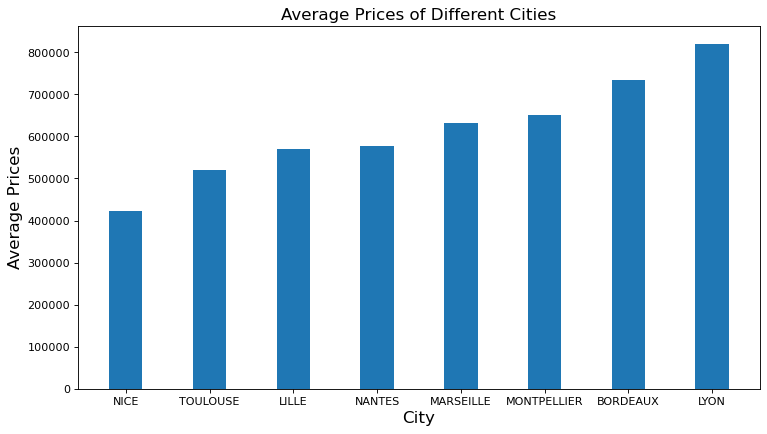

In [26]:
# plot the same graph without Paris

city_wo_paris_pd = price_city_pd[price_city_pd['city'] != 'PARIS']

figure(num = None, figsize = (11, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.title('Average Prices of Different Cities', fontsize = 15)
plt.xlabel('City', fontsize = 15)
plt.ylabel('Average Prices', fontsize = 15)

plt.bar(city_wo_paris_pd['city'], city_wo_paris_pd['average_price'], width = 0.4)
plt.show()

Without Paris, the differences between cities are much smaller. Lyon is around the double of Nice. Other cities have around 40% or less differences in average prices.

# 5. Average Price of Different Local Types

In [27]:
# extract the columns of local type and average price

property_type = spark.sql("SELECT local_type, avg(price) as average_price FROM real \
                            WHERE price < 20000000 AND local_type IS NOT NULL GROUP BY local_type")

property_type.show()

+--------------------+------------------+
|          local_type|     average_price|
+--------------------+------------------+
|               HOUSE| 483357.1576628359|
|          DEPENDENCY| 578237.8813939207|
|           APARTMENT| 635592.2419420922|
|INDUSTRIAL/COMMER...|1711521.9619956624|
+--------------------+------------------+



In [28]:
# convert data to Pandas

property_type_pd = property_type.toPandas()

property_type_pd

,local_type,average_price
0,HOUSE,4.833572e+05
1,DEPENDENCY,5.782379e+05
2,APARTMENT,6.355922e+05
3,INDUSTRIAL/COMMERCIAL LOCATION,1.711522e+06


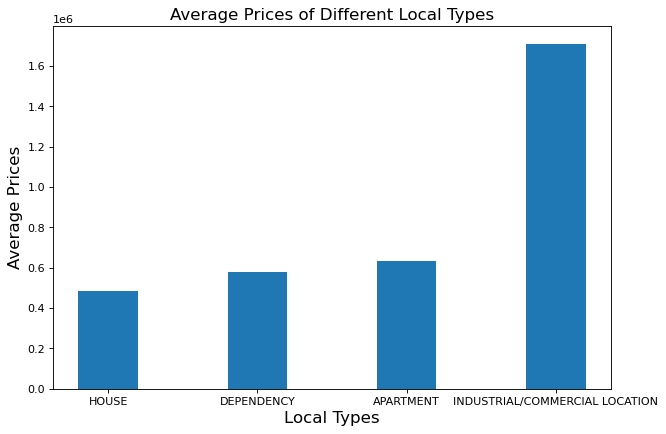

In [29]:
# plot the graph

figure(num = None, figsize = (9, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.title('Average Prices of Different Local Types', fontsize = 15)
plt.xlabel('Local Types', fontsize = 15)
plt.ylabel('Average Prices', fontsize = 15)

plt.bar(property_type_pd['local_type'], property_type_pd['average_price'], width = 0.4)
plt.show()

The highest average price belongs to industrial/commerical location, around 4 times of house, the one with the lowest average price. The other two don't have huge differences in price. Let's see the differences between house and apartment. 

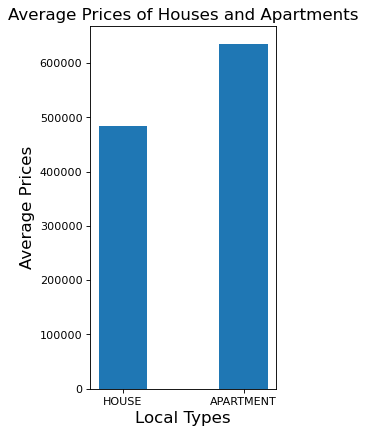

In [30]:
# plot the graph of house and apartment only

property_type_house_app_pd = property_type_pd[(property_type_pd['local_type'] == 'HOUSE') | (property_type_pd['local_type'] == 'APARTMENT')] 

figure(num = None, figsize = (3, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.title('Average Prices of Houses and Apartments', fontsize = 15)
plt.xlabel('Local Types', fontsize = 15)
plt.ylabel('Average Prices', fontsize = 15)

plt.bar(property_type_house_app_pd['local_type'], property_type_house_app_pd['average_price'], width = 0.4)
plt.show()

Surprisingly the average price of apartment is higher than that of house, around 30% higher. 

# 6. Average Sales of Different Sale Types

In [31]:
# extract sale type and average price columns

sale_type = spark.sql("SELECT sale_type, avg(price) as average_price FROM real \
                        WHERE price < 20000000 GROUP BY sale_type ORDER BY average_price")

sale_type.show()

+--------------------+-----------------+
|           sale_type|    average_price|
+--------------------+-----------------+
|            EXCHANGE| 188305.096730251|
|        ADJUDICATION|598097.2423961251|
|       EXPROPRIATION| 619036.362244898|
|                SALE|732433.2807585178|
|SALE BEFORE COMPL...| 844208.757120622|
|      LAND ONLY SALE| 1003966.72520549|
+--------------------+-----------------+



In [32]:
# convert data to Pandas

sale_type_pd = sale_type.toPandas()

sale_type_pd

,sale_type,average_price
0,EXCHANGE,1.883051e+05
1,ADJUDICATION,5.980972e+05
2,EXPROPRIATION,6.190364e+05
3,SALE,7.324333e+05
4,SALE BEFORE COMPLETION,8.442088e+05
5,LAND ONLY SALE,1.003967e+06


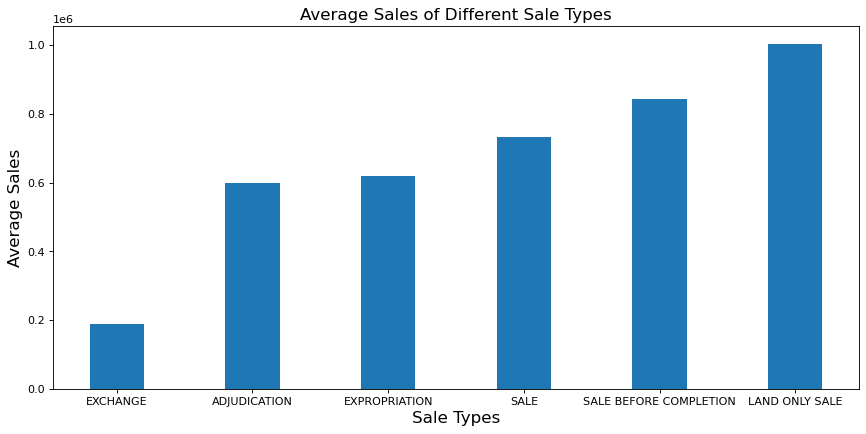

In [33]:
# plot the graph

figure(num = None, figsize = (13, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.title('Average Sales of Different Sale Types', fontsize = 15)
plt.xlabel('Sale Types', fontsize = 15)
plt.ylabel('Average Sales', fontsize = 15)

plt.bar(sale_type_pd['sale_type'], sale_type_pd['average_price'], width = 0.4)
plt.show()

The average prices among different categories vary a lot. The lowest is exchange, 5 times lower than land only sale which is the highest. 

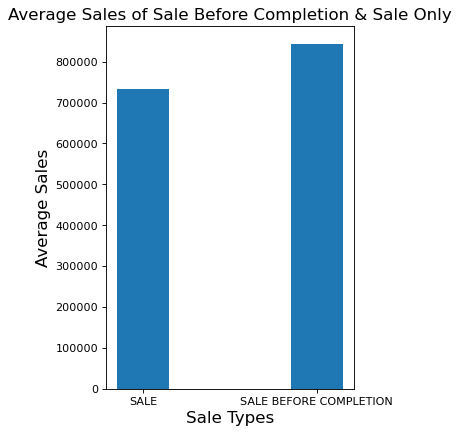

In [34]:
# plot the graph of sale before completion and sale only

sale_type_sale_only_pd = sale_type_pd[(sale_type_pd['sale_type'] == 'SALE BEFORE COMPLETION') | \
                                      (sale_type_pd['sale_type'] == 'SALE')]

figure(num = None, figsize = (4, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.title('Average Sales of Sale Before Completion & Sale Only', fontsize = 15)
plt.xlabel('Sale Types', fontsize = 15)
plt.ylabel('Average Sales', fontsize = 15)

plt.bar(sale_type_sale_only_pd['sale_type'], sale_type_sale_only_pd['average_price'], width = 0.3)
plt.show()

Sale before completion has higher average sales than sale has. Compared to other graphs and categories, the differences in average sales is much smaller which is less than 20%. 

# 7. Average Living Area of Different Cities

In [35]:
# extract city and average living area columns

avg_living_area = spark.sql("SELECT city, avg(living_area) AS average_living_area \
                            FROM real WHERE living_area != 0 AND living_area < 5000 \
                            GROUP BY city ORDER BY average_living_area")

avg_living_area.show()

+-----------+-------------------+
|       city|average_living_area|
+-----------+-------------------+
|       NICE|  64.48635088219908|
|MONTPELLIER|  64.91417857648224|
|      PARIS|  66.29860917078017|
|      LILLE|  72.22234743707953|
|  MARSEILLE|  72.62060670147379|
|   TOULOUSE|  72.87871330638073|
|       LYON|  78.09290780141843|
|     NANTES|  80.77622118237845|
|   BORDEAUX|  82.63002296211252|
+-----------+-------------------+



In [36]:
# convert data to Pandas

avg_living_area_pd = avg_living_area.toPandas()

avg_living_area_pd

,city,average_living_area
0,NICE,64.486351
1,MONTPELLIER,64.914179
2,PARIS,66.298609
3,LILLE,72.222347
4,MARSEILLE,72.620607
5,TOULOUSE,72.878713
6,LYON,78.092908
7,NANTES,80.776221
8,BORDEAUX,82.630023


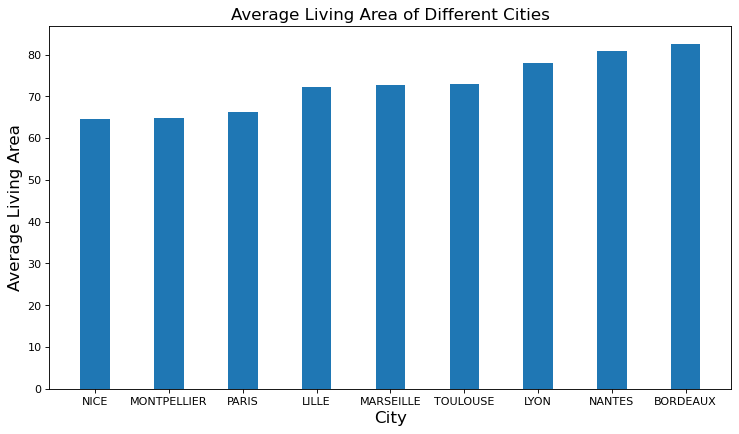

In [37]:
# plot the graph

figure(num = None, figsize = (11, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.title('Average Living Area of Different Cities', fontsize = 15)
plt.xlabel('City', fontsize = 15)
plt.ylabel('Average Living Area', fontsize = 15)

plt.bar(avg_living_area_pd['city'], avg_living_area_pd['average_living_area'], width = 0.4)
plt.show()

The differences of average living area are small. Surprsingly the lowest is Nice but not Paris. The highest is Bordeaux.

# 8. No of Sale and Sale Before Completion & Sale

In [38]:
# extract city, sale type, and no of sale type columns

sale_type_city = spark.sql("SELECT city, sale_type, count(sale_type) AS no_of_sale_type FROM real \
                            WHERE sale_type = 'SALE BEFORE COMPLETION' OR sale_type = 'SALE' \
                           GROUP BY city, sale_type ORDER BY city, sale_type, no_of_sale_type")

sale_type_city.show()

+-----------+--------------------+---------------+
|       city|           sale_type|no_of_sale_type|
+-----------+--------------------+---------------+
|   BORDEAUX|                SALE|          51159|
|   BORDEAUX|SALE BEFORE COMPL...|          14321|
|      LILLE|                SALE|          40275|
|      LILLE|SALE BEFORE COMPL...|           9597|
|       LYON|                SALE|          67472|
|       LYON|SALE BEFORE COMPL...|          14773|
|  MARSEILLE|                SALE|         103247|
|  MARSEILLE|SALE BEFORE COMPL...|          29226|
|MONTPELLIER|                SALE|          40281|
|MONTPELLIER|SALE BEFORE COMPL...|          14919|
|     NANTES|                SALE|          51803|
|     NANTES|SALE BEFORE COMPL...|          19583|
|       NICE|                SALE|          60352|
|       NICE|SALE BEFORE COMPL...|           6868|
|      PARIS|                SALE|         255117|
|      PARIS|SALE BEFORE COMPL...|           9170|
|   TOULOUSE|                SA

In [39]:
# convert data to Pandas

sale_type_city_pd = sale_type_city.toPandas()

sale_type_city_pd

,city,sale_type,no_of_sale_type
0,BORDEAUX,SALE,51159
1,BORDEAUX,SALE BEFORE COMPLETION,14321
2,LILLE,SALE,40275
3,LILLE,SALE BEFORE COMPLETION,9597
4,LYON,SALE,67472
5,LYON,SALE BEFORE COMPLETION,14773
6,MARSEILLE,SALE,103247
7,MARSEILLE,SALE BEFORE COMPLETION,29226
8,MONTPELLIER,SALE,40281
9,MONTPELLIER,SALE BEFORE COMPLETION,14919


In [40]:
import matplotlib
import numpy as np

# divide the data into sale and sale before completion types

sale_before_completion_array = sale_type_city_pd[sale_type_city_pd['sale_type'] == 'SALE BEFORE COMPLETION']
sale_array = sale_type_city_pd[sale_type_city_pd['sale_type'] == 'SALE']

# set the graph's parameters

labels = sale_array['city'].unique()
labels_location = np.arange(len(labels))
x = np.arange(len(labels))
width = 0.4

### a. Sale Types of Different Cities

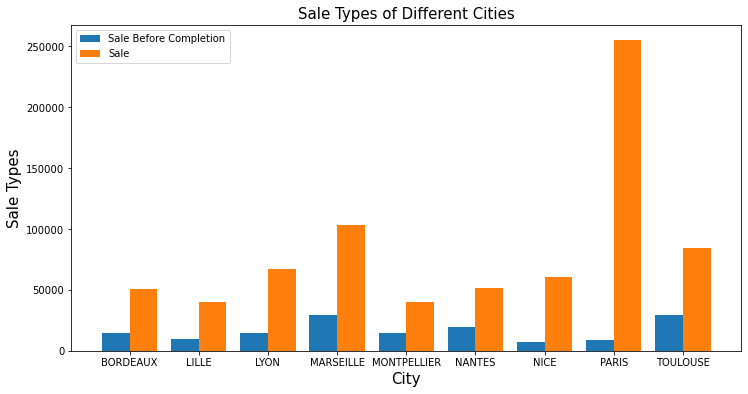

In [41]:
# plot the graph

fig, ax = plt.subplots(figsize = (12, 6))
bar1 = ax.bar(x - width/2, sale_before_completion_array['no_of_sale_type'], width, label = 'Sale Before Completion')
bar2 = ax.bar(x + width/2, sale_array['no_of_sale_type'], width, label = 'Sale')

ax.set_title('Sale Types of Different Cities', fontsize = 15)
ax.set_xlabel('City', fontsize = 15)
ax.set_ylabel('Sale Types', fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

In terms of number of sale type, sale dominates across all cities. The biggest difference lies in Paris, with count of sale having ten times more than that of sale before completion. Other cities show the same tendancy but with much less extent.
Let's look into cities' sale and sale before completion separately.

### b. Sale Before Completion Across Different Cities

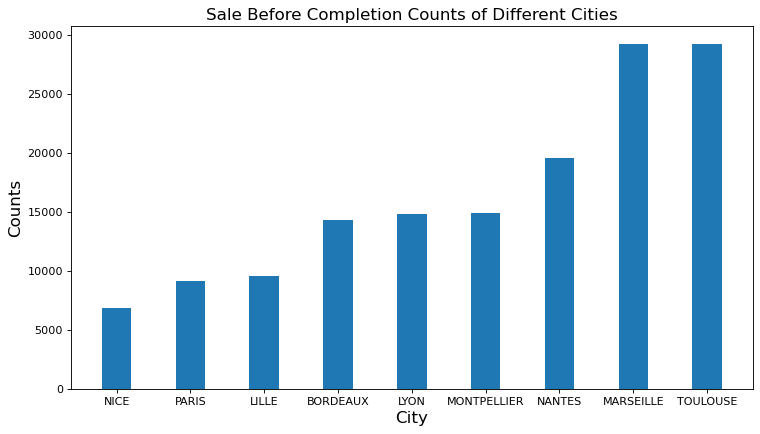

In [42]:
# plot the graph of sale before completion across different cities

sale_before_completion_array_sorted = sale_before_completion_array.sort_values(by = 'no_of_sale_type')

figure(num = None, figsize = (11, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.title('Sale Before Completion Counts of Different Cities', fontsize = 15)
plt.xlabel('City', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)

plt.bar(sale_before_completion_array_sorted['city'], sale_before_completion_array_sorted['no_of_sale_type'], width = 0.4)
plt.show()

Southern cities, Marseille and Toulouse, have the highest number of sale before completion while the biggest city, Paris, has the second lowest number.

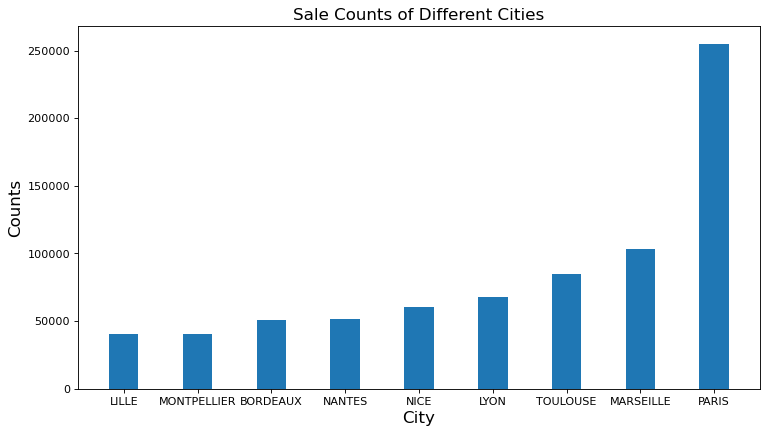

In [43]:
# plot the graph of sale cross different cities

sale_array_sorted = sale_array.sort_values(by = 'no_of_sale_type')

figure(num = None, figsize = (11, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.title('Sale Counts of Different Cities', fontsize = 15)
plt.xlabel('City', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)

plt.bar(sale_array_sorted['city'], sale_array_sorted['no_of_sale_type'], width = 0.4)
plt.show()

Paris has the highest sale count, more than 5 times of that of the lowest - Lille. Even the second highest city, Marseille, has 2 times less than Paris. Hence Paris contributes a majority of number of sale. 